In [1]:
from PIL import Image
import numpy as np
import cv2

def convert_to_thresh(img):
  gray = cv2.cvtColor(np.array(img.convert('RGB'))[:, :, ::-1].copy(), cv2.COLOR_BGR2GRAY)
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]  
  thresh[thresh == 255] = 1
  return thresh

class MyImage:
  def __init__(self, src):
    self.raw = Image.open(src)
    self.thresh = convert_to_thresh(self.raw)
    self.height, self.width = self.thresh.shape
    (_, _, self.ccs, _) = cv2.connectedComponentsWithStats(self.thresh, 8, cv2.CV_32S)
    assert len(self.ccs) == 2
    self.neume_loc = self.ccs[0]
    if self.ccs[1][-1] < self.neume_loc[-1]:
      self.neume_loc = self.ccs[1]
    (self.x, self.y, self.w, self.h, self.a) = self.neume_loc

    self.neume = self.thresh[self.y : self.y + self.h, self.x : self.x + self.w]

  def resize_neume(self, other):
    rh = other.h / self.h
    rw = other.w / self.w

    print(f'rh={rh}, rw={rw}, self.a={self.a}, other.a={other.a}')

    self.resized_a = self.a * rh * rw
    self.resized = cv2.resize(self.neume, other.neume.shape[::-1], interpolation = cv2.INTER_AREA)

  def compute_similarity(self, other):
    from scipy import signal
    # return np.sum(self.resized * other.neume) / max(other.a
    def compute_hist_loss(a):
      h1 = np.sum(self.resized, axis=a)
      h2 = np.sum(other.neume, axis=a)
      return np.mean(np.square(h1 - h2))

    return compute_hist_loss(0) + compute_hist_loss(1)

    new_img = signal.fftconvolve(self.resized, other.neume, mode='valid')
    print(f'shape={new_img.shape}')

    print(f'self.resized_a={self.resized_a}, other.a={other.a}')
    print(f'value={new_img[0][0]}')

    return new_img[0][0] / max(self.resized_a, other.a)

  def plot_neume(self):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Display the image
    x0, x1 = self.x, self.x + self.w
    y0, y1 = self.y, self.y + self.h
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(self.h / 10, self.w / 10))

    ax.imshow(self.thresh[y0 : y1, x0 : x1])
    plt.show()  

  def plot_resized_neume(self):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Create figure and axes
    print(f'shape={self.resized.shape}')
    fig, ax = plt.subplots(figsize=(self.resized.shape[0] / 10, self.resized.shape[1] / 10))
    ax.imshow(self.resized)
    plt.show()

  def plot_ccs(self):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(self.height / 10, self.width / 10))

    # Display the image
    ax.imshow(self.raw)

    # Create a Rectangle patch
    for index, (x, y, w, h, a) in enumerate(self.ccs):
      rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label=f'{index}')
      ax.add_patch(rect)
      # rx, ry = rect.get_xy()
      # cx = rx + rect.get_width() / 2.0
      # cy = ry + rect.get_height() / 2.0
      # ax.annotate(f'{index}', (cx, cy), color='green', weight='bold', fontsize=16, ha='center', va='center')
    plt.show()
      

img1 = MyImage('neumes/psiphiston/psiphiston_1.png')
img2 = MyImage('neumes/petasti/petasti_1.png')

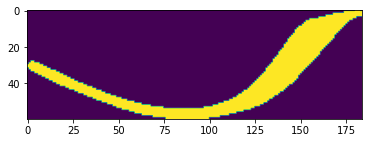

In [2]:
img1.plot_neume()

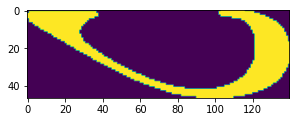

In [3]:
img2.plot_neume()

In [4]:
img2.resize_neume(img1)

rh=1.2765957446808511, rw=1.3142857142857143, self.a=1684, other.a=1872


shape=(60, 184)


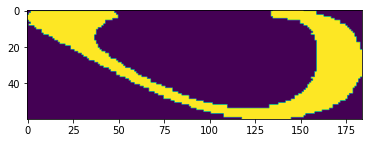

In [5]:
img2.plot_resized_neume()

In [6]:
# import matplotlib.pyplot as plt
# from scipy import signal
# print(resized.shape)
# print(img1[:,:,np.newaxis].shape)
# new_img = signal.fftconvolve(resized, img1, mode='same')
# index = np.unravel_index(np.argmax(new_img), new_img.shape)
# print(f'index={index}')
# plt.figure()
# plt.imshow(new_img)
print(img2.compute_similarity(img1))

711.6844202898551
